In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
folder_path = '../data/Traffic_data'

dataframes = {}

for file in os.listdir(folder_path):
    if file.endswith('.traffic.htm'):
        file_path = os.path.join(folder_path, file)
        file_name = file.split('.')[0]
        df_list = pd.read_html(file_path)
        df = df_list[4]
        df = df.iloc[1:].reset_index(drop=True)
        df_key = file_name
        dataframes[df_key] = df

In [3]:
traffic_df = pd.read_csv('../data/traffic_df.csv', sep=',')

C:\Users\julia\AppData\Local\Temp\ipykernel_11788\534620213.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('hsv', len(unique_road_names))


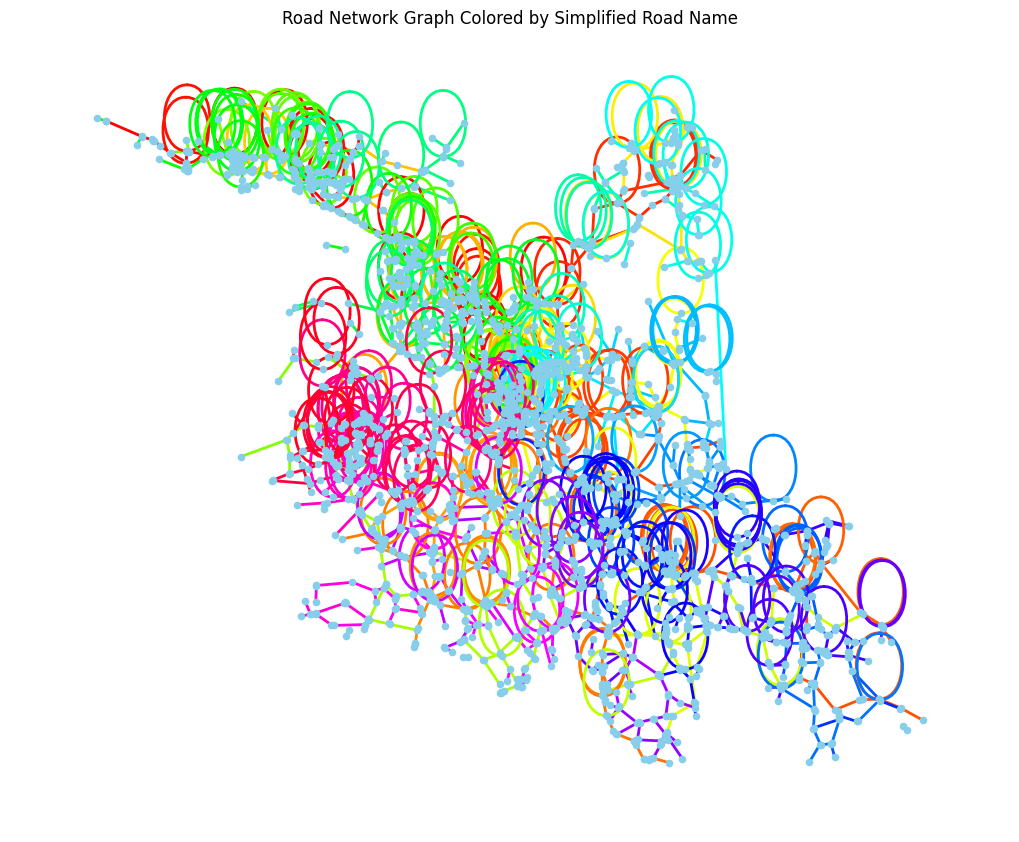

In [4]:
# Load the datasets
traffic_df = pd.read_csv('../data/traffic_df.csv')
roads_df = pd.read_csv('../data/_roads3.csv')

# Create simplified road names in the traffic dataset
traffic_df['SimplifiedRoadName'] = traffic_df['Road'].apply(lambda x: x.split('-')[0].strip())

# Create a unique identifier for each LRP that includes its road
traffic_df['LRP_Unique'] = traffic_df['SimplifiedRoadName'] + "_" + traffic_df['LRP']
traffic_df['LRP_2_Unique'] = traffic_df['SimplifiedRoadName'] + "_" + traffic_df['LRP_2']

# Assuming roads_df has 'lrp', 'lon', 'lat', and a road identifier that matches traffic_df['SimplifiedRoadName']
roads_df['LRP_Unique'] = roads_df['road'] + "_" + roads_df['lrp']  # Adjust 'Road' to the correct column name if different

# Create a dictionary to map LRP_Unique to coordinates
lrp_to_coords = {row['LRP_Unique']: (row['lat'], row['lon']) for index, row in roads_df.iterrows()}

# Initialize the graph
G = nx.Graph()

# Add edges to the graph, using the unique LRP identifiers to set positions
for index, row in traffic_df.iterrows():
    start_node = row['LRP_Unique']
    end_node = row['LRP_2_Unique']
    length_km = row['(Km)']  # Assuming this is the length column
    simplified_road_name = row['SimplifiedRoadName']
    # Check if both nodes have coordinates before adding the edge
    if start_node in lrp_to_coords and end_node in lrp_to_coords:
        G.add_edge(start_node, end_node, length=length_km, road_name=simplified_road_name)

# Assign coordinates to nodes in the graph
for node in G.nodes:
    if node in lrp_to_coords:
        G.nodes[node]['pos'] = lrp_to_coords[node]

# Create a unique color for each simplified road name
unique_road_names = traffic_df['SimplifiedRoadName'].unique()
colors = plt.cm.get_cmap('hsv', len(unique_road_names))
road_name_to_color = {road: colors(i) for i, road in enumerate(unique_road_names)}

# Visualization
plt.figure(figsize=(10, 8))
edge_colors = [road_name_to_color[G.edges[edge]['road_name']] for edge in G.edges() if 'road_name' in G.edges[edge]]

nx.draw(G, pos=lrp_to_coords, with_labels=False, node_size=20, font_size=8, node_color='skyblue', edge_color=edge_colors, width=2)
plt.title('Road Network Graph Colored by Simplified Road Name')
plt.show()

In [92]:
df = pd.read_csv('../data/traffic_df_with_bridges.csv')
df.head(5)

,Road,Name,LRP,Offset,Chainage,LRP_2,Offset_2,Chainage_2,(Km),Heavy Truck,...,Cart,Motorized,Non Motorized,Total AADT,(AADT),base_road,condition,lat,lon,Type
0,N1-1L,Jatrabari - Int.with Z1101 (Left) (Left),LRPS,0.0,0.000,LRPS,822.0,0.822,0.822,402.0,...,0.0,18236.0,1121.0,19357.0,19357.0,N1,NaN,23.706028,90.443333,Intersection
1,N1-1R,Jatrabari - Int.with Z1101 (Left) (Right),LRPS,0.0,0.000,LRPS,822.0,0.822,0.822,660.0,...,0.0,20236.0,1301.0,21537.0,21537.0,N1,NaN,23.706028,90.443333,Intersection
2,N1-2L,Int.with Z1101 - Signboard (Left) R111 (Left),LRPS,822.0,0.822,LRPS,4175.0,4.175,3.353,660.0,...,0.0,20236.0,1301.0,21537.0,21537.0,N1,NaN,23.702778,90.450472,Intersection
3,N1-2R,Int.with Z1101 - Signboard (Left) R111 (Right),LRPS,822.0,0.822,LRPS,4175.0,4.175,3.353,402.0,...,0.0,18236.0,1121.0,19357.0,19357.0,N1,NaN,23.702778,90.450472,Intersection
4,NaN,.,NaN,NaN,1.800,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,N1,A,23.698739,90.458861,Bridge


In [111]:
index_bridges = df[df['Road'].isnull()].index
index_roads = df[df['Road'].notnull()].index
df['Type'] = pd.NA
df.loc[index_roads, 'Type'] = 'Road'
df.loc[index_bridges, 'Type'] = 'Bridge'

df['Connected_Road1'] = None
df['Connected_Road2'] = None
df['Connected_Road3'] = None

all_road_names = df['Name'].str.findall(r'(N\d+|R\d+|Z\d+)')

for index, matches in all_road_names.items():
    # Ensure matches is a list; treat NaN (float) as an empty list
    matches = matches if isinstance(matches, list) else []
    
    if len(matches) >= 1:
        df.at[index, 'Connected_Road1'] = matches[0]
    if len(matches) >= 2:
        df.at[index, 'Connected_Road2'] = matches[1]
    if len(matches) >= 3:
        df.at[index, 'Connected_Road3'] = matches[2]

df.loc[df['Connected_Road1'].notna(), 'Type'] = 'Intersection'
df.to_csv('../data/traffic_df_with_bridges_and_intersections.csv', index=False)

In [109]:
# Assuming all_road_names is already created as shown previously
# all_road_names = df['Name'].str.findall(r'(N\d+|R\d+|Z\d+)')

# Identify rows with more than three road names
more_than_three_roads = all_road_names.apply(lambda x: len(x) > 3 if isinstance(x, list) else False)

# Optional: Extract indices of rows with more than three road names
indices_more_than_three_roads = more_than_three_roads[more_than_three_roads].index

# Display the indices
indices_more_than_three_roads

Index([], dtype='int64')

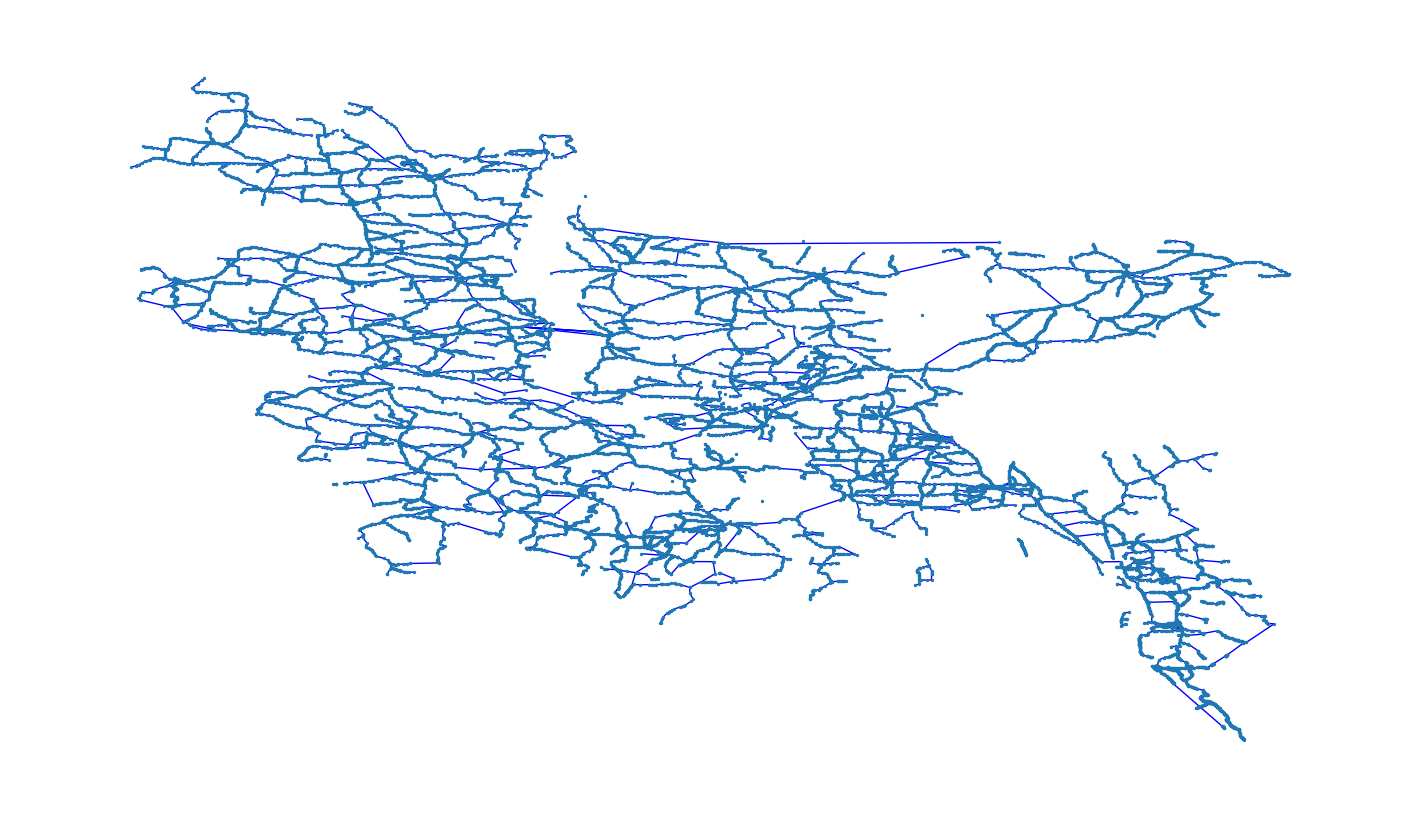

In [34]:
positions = {index: (row['lon'], row['lat']) for index, row in df.iterrows()}
# Ensure the data is sorted by 'base_road' and 'Chainage'
df_sorted = df.sort_values(by=['base_road', 'Chainage'])

# Creating a new DataFrame to hold nodes with positions and chainage for connection logic
df_nodes = df_sorted[['lat', 'lon', 'Chainage', 'base_road']].dropna()

# Reset index to ensure the nodes are indexed sequentially for graph construction
df_nodes.reset_index(drop=True, inplace=True)

# Create positions dictionary again based on the sorted and cleaned DataFrame
positions = {index: (row['lon'], row['lat']) for index, row in df_nodes.iterrows()}

# Create the graph again
G = nx.Graph()

# Add nodes with positions and additional attributes (for potential future use)
for node, row in df_nodes.iterrows():
    G.add_node(node, pos=(row['lon'], row['lat']), chainage=row['Chainage'], base_road=row['base_road'])

# Add edges based on sequential chainage within the same base_road
for i in range(len(df_nodes) - 1):
    if df_nodes.iloc[i]['base_road'] == df_nodes.iloc[i+1]['base_road']:
        G.add_edge(i, i+1)

# Extract positions from graph nodes for plotting
# Draw the graph, including edges
# Add nodes with positions
for node, pos in positions.items():
    G.add_node(node, pos=pos)

# Extract positions from graph nodes for plotting
pos = nx.get_node_attributes(G, 'pos')
plt.figure(figsize=(14, 8))
# Draw the graph
nx.draw(G, pos, node_size=2, with_labels=False, edge_color='b')  # Adjust node_size for better visibility, with_labels for node ids
plt.show()